## Training

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN

from torchvision.models.detection.rpn import AnchorGenerator

import albumentations as A
import cv2
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import json

In [3]:
BATCH_SIZE = 3 # increase / decrease according to GPU memeory
RESIZE_TO = 400 # resize the image for training and transforms
NUM_EPOCHS = 50 # number of epochs to train for
NUM_WORKERS = 1
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory
TRAIN_DIR = '/content/drive/MyDrive/Gaspipe_Project/Dataset/train'
# validation images and XML files directory
VALID_DIR = '/content/drive/MyDrive/Gaspipe_Project/Dataset/valid'
# classes: 0 index is reserved for background
CLASSES = [
    '__background__', 'clamp','pipe'
]
NUM_CLASSES = len(CLASSES)
# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = True
# location to save model and plots
OUT_DIR = '/content/drive/MyDrive/Gaspipe_Project/Output'

In [4]:
# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [5]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, '/content/drive/MyDrive/Gaspipe_Project/Output/best_model.pth')

In [6]:
# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    # count = 0
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            # print(f"Counter:{count}")
            # print(f"Images:{images}")
            # print(f"Targets:{targets}")
            count += 1
            images = list(image.to(DEVICE) for image in images)
            # print(f"Type of images:{type(images)}")
            # print(f"Type of targets:{type(targets)}")
            #targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            # boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            # labels = targets[i]['labels'].cpu().numpy().astype(np.int32)
            # sample = images[i].permute(1, 2, 0).cpu().numpy()
            # for box_num, box in enumerate(boxes):
            #     cv2.rectangle(sample,
            #                 (box[0], box[1]),
            #                 (box[2], box[3]),
            #                 (0, 0, 255), 2)
            #     cv2.putText(sample, CLASSES[labels[box_num]],
            #                 (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX,
            #                 1.0, (0, 0, 255), 2)
            # cv2.imshow('Transformed image', sample)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()

In [7]:
import os
import glob as glob
from xml.etree import ElementTree as et
from google.colab.patches import cv2_imshow

# the dataset class
class CustomDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes

        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0

        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]

        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))

            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)

            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            yamx_final = (ymax/image_height)*self.height

            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])

        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return image_resized, target
    def __len__(self):
        return len(self.all_images)

# prepare the final datasets and data loaders
def create_train_dataset():
    train_dataset = CustomDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
    return train_dataset
def create_valid_dataset():
    valid_dataset = CustomDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
    return valid_dataset
def create_train_loader(train_dataset, num_workers=1):
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers
    )
    return train_loader
def create_valid_loader(valid_dataset, num_workers=1):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers
    )
    return valid_loader

Number of training images: 15


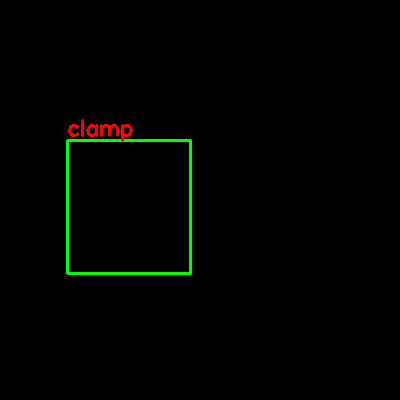

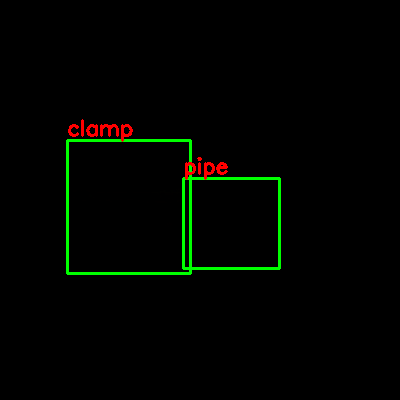

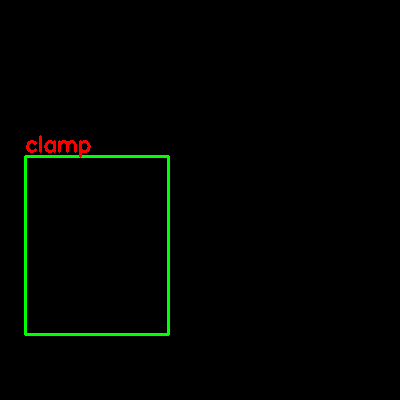

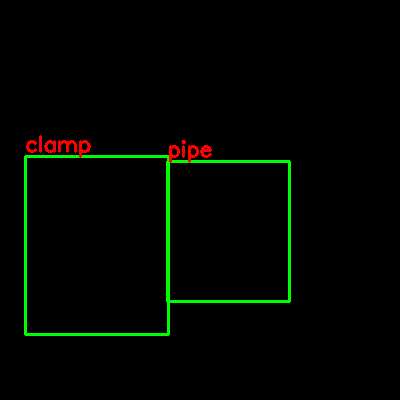

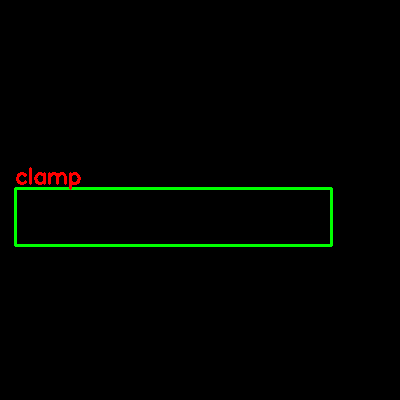

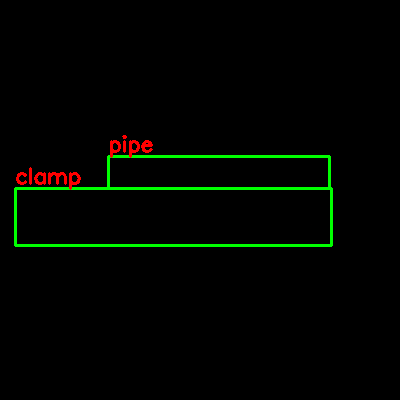

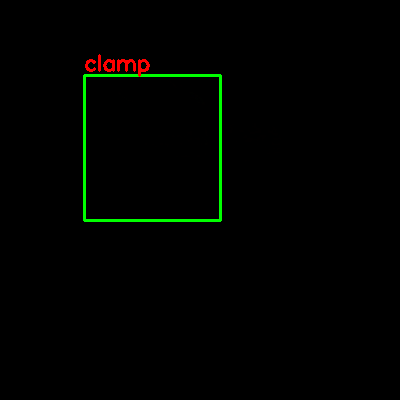

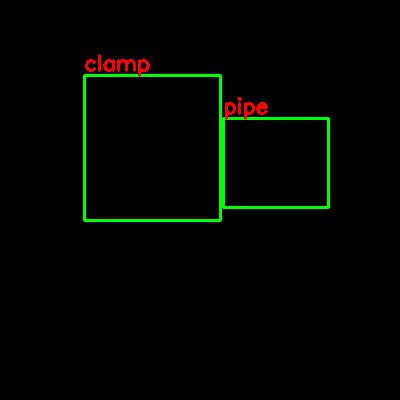

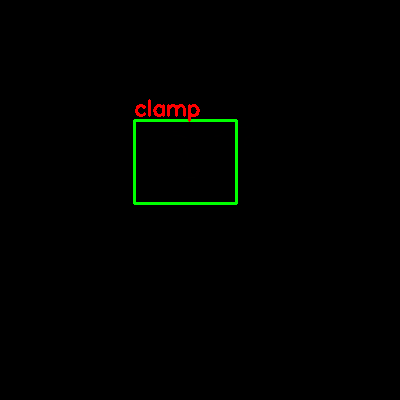

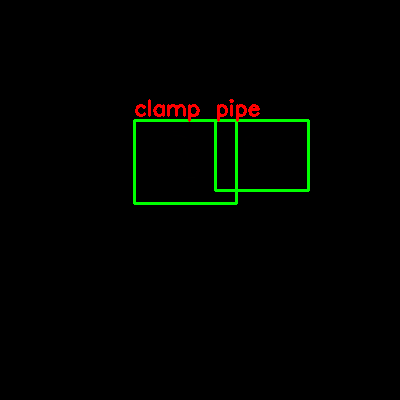

In [8]:
dataset = CustomDataset(
        TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES
    )
print(f"Number of training images: {len(dataset)}")

# function to visualize a single sample
def visualize_sample(image, target):
  for box_num in range(len(target['boxes'])):
    box = target['boxes'][box_num]
    label = CLASSES[target['labels'][box_num]]
    cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),(0, 255, 0), 2)
    cv2.putText(image, label, (int(box[0]), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    cv2_imshow(image)
    cv2.waitKey(0)

NUM_SAMPLES_TO_VISUALIZE = 5
for i in range(NUM_SAMPLES_TO_VISUALIZE):
  image, target = dataset[i]
  visualize_sample(image, target)

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):

    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [10]:
train_dataset = create_train_dataset()
valid_dataset = create_valid_dataset()
train_loader = create_train_loader(train_dataset, NUM_WORKERS)
valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")
# initialize the model and move to the computation device
model = create_model(num_classes=3)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:161: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of training samples: 15
Number of validation samples: 4



Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 165MB/s]


In [18]:
from tqdm.auto import tqdm
import time
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list

     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        if isinstance(targets, dict):
          target_list = []
          num_images = targets['boxes'].size(0)  # Get the number of images from the 'boxes' tensor

          for i in range(num_images):
              tmp_dict = {
                  'boxes': targets['boxes'][i],        # Access the boxes for the i-th image
                  'labels': targets['labels'][i],      # Access the labels for the i-th image
                  'area': targets['area'][i],          # Access the area for the i-th image
                  'iscrowd': targets['iscrowd'][i],   # Access the iscrowd for the i-th image
                  'image_id': targets['image_id'][i]   # Access the image_id for the i-th image
              }
              target_list.append(tmp_dict)

          #print(f"Target_list values: {target_list}")

        print(f"Type of targets: {type(target_list)}")
        print(f"Number of targets: {len(target_list)}")
        for idx, target in enumerate(target_list):
          print(f"Target {idx}: Type: {type(target)}, Content: {target}")

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in target_list] # targets is a single dict with data of all images in each batch. This is not a supported format for the model.




        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [19]:
# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data

        if isinstance(targets, dict):
            target_list = []
            num_images = targets['boxes'].size(0)  # Get the number of images from the 'boxes' tensor

            for i in range(num_images):
                tmp_dict = {
                    'boxes': targets['boxes'][i],        # Access the boxes for the i-th image
                    'labels': targets['labels'][i],      # Access the labels for the i-th image
                    'area': targets['area'][i],          # Access the area for the i-th image
                    'iscrowd': targets['iscrowd'][i],   # Access the iscrowd for the i-th image
                    'image_id': targets['image_id'][i]   # Access the image_id for the i-th image
                }
                target_list.append(tmp_dict)

            #print(f"Target_list values: {target_list}")

        print(f"Type of targets: {type(target_list)}")
        print(f"Number of targets: {len(target_list)}")
        for idx, target in enumerate(target_list):
            print(f"Target {idx}: Type: {type(target)}, Content: {target}")

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in target_list]

        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [20]:
def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, '/content/drive/MyDrive/Gaspipe_Project/Output/last_model.pth')
def save_loss_plot(OUT_DIR, train_loss, val_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    train_ax.plot(train_loss, color='tab:blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss, color='tab:red')
    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"{OUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUT_DIR}/valid_loss.png")
    print('SAVING PLOTS COMPLETE...')
    plt.close('all')

In [21]:
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []
# name to save the trained model with
MODEL_NAME = 'model'
# whether to show transformed images from data loader or not
# if VISUALIZE_TRANSFORMED_IMAGES:
#         show_tranformed_image(train_loader)
# initialize SaveBestModel class
save_best_model = SaveBestModel()

# start the training epochs
for epoch in range(NUM_EPOCHS):
  print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
  # reset the training and validation loss histories for the current epoch
  train_loss_hist.reset()
  val_loss_hist.reset()
  # start timer and carry out training and validation
  start = time.time()
  train_loss = train(train_loader, model)
  val_loss = validate(valid_loader, model)
  print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
  print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")
  end = time.time()
  print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
  # save the best model till now if we have the least loss in the...
  # ... current epoch
  save_best_model(
            val_loss_hist.value, epoch, model, optimizer
        )
  # save the current epoch model
  save_model(epoch, model, optimizer)
  # save loss plot
  save_loss_plot(OUT_DIR, train_loss, val_loss)

  # # sleep for 5 seconds after each epoch
  # time.sleep(5)


EPOCH 1 of 50
Training


  0%|          | 0/5 [00:05<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[111.2500, 156.8750, 220.0000, 239.3750],
        [211.2500, 167.5000, 280.6250, 240.0000]]), 'labels': tensor([1, 2]), 'area': tensor([8971.8750, 5029.6875]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([10])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[231.8750, 156.8750, 375.0000, 334.3750],
        [110.6250, 161.8750, 232.5000, 301.8750]]), 'labels': tensor([1, 2]), 'area': tensor([25404.6875, 17062.5000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[196.8750, 163.1250, 280.0000, 265.6250],
        [210.0000,  91.8750, 279.3750, 184.3750]]), 'labels': tensor([1, 2]), 'area': tensor([8520.3125, 6417.1875]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([4])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[170.6250, 170.6250

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 84.3750,  75.6250, 220.0000, 220.0000],
        [223.1250, 118.1250, 328.1250, 207.5000]]), 'labels': tensor([1, 2]), 'area': tensor([19580.8594,  9384.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([3])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 91.2500, 156.8750, 177.5000, 234.3750],
        [172.5000, 161.2500, 223.1250, 225.0000]]), 'labels': tensor([1, 2]), 'area': tensor([6684.3750, 3227.3438]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([9])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 63.7500, 140.0000, 210.6250, 272.5000],
        [206.2500, 154.3750, 297.5000, 270.0000]]), 'labels': tensor([1, 2]), 'area': tensor([19460.9375, 10550.7812]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([7])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[170.6250, 137.500

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[103.1250, 102.5000, 239.3750, 228.7500],
        [230.6250, 116.2500, 340.0000, 221.2500]]), 'labels': tensor([1, 2]), 'area': tensor([17201.5625, 11484.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([12])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[122.5000, 183.7500, 236.8750, 297.5000],
        [124.3750,  95.0000, 215.6250, 190.0000]]), 'labels': tensor([1, 2]), 'area': tensor([13010.1562,  8668.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([14])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[143.7500, 137.5000, 229.3750, 229.3750],
        [221.2500, 165.0000, 271.2500, 225.0000]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[135.0000,  96.2

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[118.7500, 131.2500, 238.1250, 246.2500],
        [118.7500,  49.3750, 203.7500, 145.6250]]), 'labels': tensor([1, 2]), 'area': tensor([13728.1250,  8181.2500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([11])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[163.1250, 120.0000, 265.6250, 203.1250],
        [ 91.8750, 120.6250, 184.3750, 190.0000]]), 'labels': tensor([1, 2]), 'area': tensor([8520.3125, 6417.1875]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([4])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 81.8750,  76.2500, 230.6250, 210.0000],
        [199.3750,  71.8750, 336.8750, 166.2500]]), 'labels': tensor([1, 2]), 'area': tensor([19895.3125, 12976.5625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([5])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[222.5000, 165.62

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[153.7500, 118.7500, 268.7500, 238.1250],
        [254.3750, 118.7500, 350.6250, 203.7500]]), 'labels': tensor([1, 2]), 'area': tensor([13728.1250,  8181.2500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([11])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[169.3750,  76.2500, 318.1250, 210.0000],
        [ 63.1250,  71.8750, 200.6250, 166.2500]]), 'labels': tensor([1, 2]), 'area': tensor([19895.3125, 12976.5625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([5])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[189.3750, 127.5000, 336.2500, 260.0000],
        [102.5000, 130.0000, 193.7500, 245.6250]]), 'labels': tensor([1, 2]), 'area': tensor([19460.9375, 10550.7812]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([7])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[160.6250, 171.

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[156.8750,  25.0000, 334.3750, 168.1250],
        [161.8750, 167.5000, 301.8750, 289.3750]]), 'labels': tensor([1, 2]), 'area': tensor([25404.6875, 17062.5000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 22.5000,  88.1250, 340.0000, 399.3750],
        [ 76.2500,  50.6250, 286.2500, 215.0000]]), 'labels': tensor([1, 2]), 'area': tensor([98821.8750, 34518.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([13])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[143.7500, 170.6250, 229.3750, 262.5000],
        [221.2500, 175.0000, 271.2500, 235.0000]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[196.2500, 135.00

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 88.1250,  22.5000, 399.3750, 340.0000],
        [ 50.6250,  76.2500, 215.0000, 286.2500]]), 'labels': tensor([1, 2]), 'area': tensor([98821.8750, 34518.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([13])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[131.2500, 161.8750, 246.2500, 281.2500],
        [ 49.3750, 196.2500, 145.6250, 281.2500]]), 'labels': tensor([1, 2]), 'area': tensor([13728.1250,  8181.2500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([11])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[111.2500, 156.8750, 220.0000, 239.3750],
        [211.2500, 167.5000, 280.6250, 240.0000]]), 'labels': tensor([1, 2]), 'area': tensor([8971.8750, 5029.6875]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([10])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[196.2500, 135.

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[135.0000, 196.2500, 243.1250, 303.7500],
        [168.7500, 138.7500, 243.7500, 196.8750]]), 'labels': tensor([1, 2]), 'area': tensor([11623.4375,  4359.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([6])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 25.0000,  65.6250, 168.1250, 243.1250],
        [167.5000,  98.1250, 289.3750, 238.1250]]), 'labels': tensor([1, 2]), 'area': tensor([25404.6875, 17062.5000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[156.8750, 222.5000, 234.3750, 308.7500],
        [161.2500, 176.8750, 225.0000, 227.5000]]), 'labels': tensor([1, 2]), 'area': tensor([6684.3750, 3227.3438]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([9])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[170.6250, 170.625

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[196.2500, 156.8750, 303.7500, 265.0000],
        [138.7500, 156.2500, 196.8750, 231.2500]]), 'labels': tensor([1, 2]), 'area': tensor([11623.4375,  4359.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([6])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[160.6250, 171.2500, 296.8750, 297.5000],
        [ 60.0000, 178.7500, 169.3750, 283.7500]]), 'labels': tensor([1, 2]), 'area': tensor([17201.5625, 11484.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([12])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 15.0000, 155.0000, 331.2500, 211.8750],
        [108.1250, 211.8750, 329.3750, 243.1250]]), 'labels': tensor([1, 2]), 'area': tensor([17986.7188,  6914.0625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[161.8750, 153.

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 65.6250,  25.0000, 243.1250, 168.1250],
        [ 98.1250, 167.5000, 238.1250, 289.3750]]), 'labels': tensor([1, 2]), 'area': tensor([25404.6875, 17062.5000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[153.7500, 161.8750, 268.7500, 281.2500],
        [254.3750, 196.2500, 350.6250, 281.2500]]), 'labels': tensor([1, 2]), 'area': tensor([13728.1250,  8181.2500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([11])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[  0.6250,  60.0000, 311.8750, 377.5000],
        [185.0000, 113.7500, 349.3750, 323.7500]]), 'labels': tensor([1, 2]), 'area': tensor([98821.8750, 34518.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([13])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 91.2500, 156

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[170.6250, 143.7500, 262.5000, 229.3750],
        [175.0000, 221.2500, 235.0000, 271.2500]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 15.0000, 155.0000, 331.2500, 211.8750],
        [108.1250, 211.8750, 329.3750, 243.1250]]), 'labels': tensor([1, 2]), 'area': tensor([17986.7188,  6914.0625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[122.5000, 183.7500, 236.8750, 297.5000],
        [124.3750,  95.0000, 215.6250, 190.0000]]), 'labels': tensor([1, 2]), 'area': tensor([13010.1562,  8668.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([14])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[171.2500, 160.62

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[156.8750, 111.2500, 239.3750, 220.0000],
        [167.5000, 211.2500, 240.0000, 280.6250]]), 'labels': tensor([1, 2]), 'area': tensor([8971.8750, 5029.6875]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([10])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[231.8750, 156.8750, 375.0000, 334.3750],
        [110.6250, 161.8750, 232.5000, 301.8750]]), 'labels': tensor([1, 2]), 'area': tensor([25404.6875, 17062.5000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 15.0000, 188.1250, 331.2500, 245.0000],
        [108.1250, 156.8750, 329.3750, 188.1250]]), 'labels': tensor([1, 2]), 'area': tensor([17986.7188,  6914.0625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 67.5000, 126.25

  0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c94c80d1cf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 25.0000, 156.8750, 168.1250, 334.3750],
        [167.5000, 161.8750, 289.3750, 301.8750]]), 'labels': tensor([1, 2]), 'area': tensor([25404.6875, 17062.5000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[143.7500, 170.6250, 229.3750, 262.5000],
        [221.2500, 175.0000, 271.2500, 235.0000]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[160.6250, 111.2500, 243.1250, 220.0000],
        [160.0000, 211.2500, 232.5000, 280.6250]]), 'labels': tensor([1, 2]), 'area': tensor([8971.8750, 5029.6875]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([10])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[153.7500, 118.7500

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[196.2500, 135.0000, 303.7500, 243.1250],
        [138.7500, 168.7500, 196.8750, 243.7500]]), 'labels': tensor([1, 2]), 'area': tensor([11623.4375,  4359.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([6])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[131.2500, 118.7500, 246.2500, 238.1250],
        [ 49.3750, 118.7500, 145.6250, 203.7500]]), 'labels': tensor([1, 2]), 'area': tensor([13728.1250,  8181.2500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([11])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[180.0000,  84.3750, 324.3750, 220.0000],
        [192.5000, 223.1250, 281.8750, 328.1250]]), 'labels': tensor([1, 2]), 'area': tensor([19580.8594,  9384.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([3])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 67.5000, 140.

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 81.8750, 190.0000, 230.6250, 323.7500],
        [199.3750, 233.7500, 336.8750, 328.1250]]), 'labels': tensor([1, 2]), 'area': tensor([19895.3125, 12976.5625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([5])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[131.2500, 118.7500, 246.2500, 238.1250],
        [ 49.3750, 118.7500, 145.6250, 203.7500]]), 'labels': tensor([1, 2]), 'area': tensor([13728.1250,  8181.2500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([11])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 63.7500, 140.0000, 210.6250, 272.5000],
        [206.2500, 154.3750, 297.5000, 270.0000]]), 'labels': tensor([1, 2]), 'area': tensor([19460.9375, 10550.7812]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([7])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[  0.6250,  60.

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[189.3750, 140.0000, 336.2500, 272.5000],
        [102.5000, 154.3750, 193.7500, 270.0000]]), 'labels': tensor([1, 2]), 'area': tensor([19460.9375, 10550.7812]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([7])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[161.8750, 153.7500, 281.2500, 268.7500],
        [196.2500, 254.3750, 281.2500, 350.6250]]), 'labels': tensor([1, 2]), 'area': tensor([13728.1250,  8181.2500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([11])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[137.5000, 170.6250, 229.3750, 256.2500],
        [165.0000, 128.7500, 225.0000, 178.7500]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[102.5000, 163.12

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 91.2500, 156.8750, 177.5000, 234.3750],
        [172.5000, 161.2500, 223.1250, 225.0000]]), 'labels': tensor([1, 2]), 'area': tensor([6684.3750, 3227.3438]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([9])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[183.7500, 122.5000, 297.5000, 236.8750],
        [ 95.0000, 124.3750, 190.0000, 215.6250]]), 'labels': tensor([1, 2]), 'area': tensor([13010.1562,  8668.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([14])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[137.5000, 143.7500, 229.3750, 229.3750],
        [165.0000, 221.2500, 225.0000, 271.2500]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[169.3750, 190.0000

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 96.2500, 156.8750, 203.7500, 265.0000],
        [203.1250, 156.2500, 261.2500, 231.2500]]), 'labels': tensor([1, 2]), 'area': tensor([11623.4375,  4359.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([6])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[155.0000,  68.7500, 211.8750, 385.0000],
        [211.8750,  70.6250, 243.1250, 291.8750]]), 'labels': tensor([1, 2]), 'area': tensor([17986.7188,  6914.0625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[222.5000, 156.8750, 308.7500, 234.3750],
        [176.8750, 161.2500, 227.5000, 225.0000]]), 'labels': tensor([1, 2]), 'area': tensor([6684.3750, 3227.3438]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([9])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 75.6250,  84.375

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[153.7500, 118.7500, 268.7500, 238.1250],
        [254.3750, 118.7500, 350.6250, 203.7500]]), 'labels': tensor([1, 2]), 'area': tensor([13728.1250,  8181.2500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([11])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 76.2500,  81.8750, 210.0000, 230.6250],
        [ 71.8750, 199.3750, 166.2500, 336.8750]]), 'labels': tensor([1, 2]), 'area': tensor([19895.3125, 12976.5625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([5])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[180.0000, 156.8750, 288.7500, 239.3750],
        [119.3750, 167.5000, 188.7500, 240.0000]]), 'labels': tensor([1, 2]), 'area': tensor([8971.8750, 5029.6875]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([10])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[189.3750, 140.0

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[153.7500, 118.7500, 268.7500, 238.1250],
        [254.3750, 118.7500, 350.6250, 203.7500]]), 'labels': tensor([1, 2]), 'area': tensor([13728.1250,  8181.2500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([11])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[140.6250, 210.0000, 273.7500, 332.5000],
        [178.7500, 120.6250, 268.7500, 216.8750]]), 'labels': tensor([1, 2]), 'area': tensor([16307.8125,  8662.5000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 91.2500, 156.8750, 177.5000, 234.3750],
        [172.5000, 161.2500, 223.1250, 225.0000]]), 'labels': tensor([1, 2]), 'area': tensor([6684.3750, 3227.3438]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([9])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[170.6250, 170.62

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[102.5000, 103.1250, 228.7500, 239.3750],
        [116.2500, 230.6250, 221.2500, 340.0000]]), 'labels': tensor([1, 2]), 'area': tensor([17201.5625, 11484.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([12])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[170.6250, 143.7500, 262.5000, 229.3750],
        [175.0000, 221.2500, 235.0000, 271.2500]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[180.0000, 180.0000, 315.6250, 324.3750],
        [ 71.8750, 192.5000, 176.8750, 281.8750]]), 'labels': tensor([1, 2]), 'area': tensor([19580.8594,  9384.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([3])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[102.5000, 122.50

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[196.2500, 156.8750, 303.7500, 265.0000],
        [138.7500, 156.2500, 196.8750, 231.2500]]), 'labels': tensor([1, 2]), 'area': tensor([11623.4375,  4359.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([6])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[137.5000, 143.7500, 229.3750, 229.3750],
        [165.0000, 221.2500, 225.0000, 271.2500]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[153.7500, 118.7500, 268.7500, 238.1250],
        [254.3750, 118.7500, 350.6250, 203.7500]]), 'labels': tensor([1, 2]), 'area': tensor([13728.1250,  8181.2500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([11])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[189.3750, 127.50

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[118.7500, 131.2500, 238.1250, 246.2500],
        [118.7500,  49.3750, 203.7500, 145.6250]]), 'labels': tensor([1, 2]), 'area': tensor([13728.1250,  8181.2500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([11])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[143.7500, 170.6250, 229.3750, 262.5000],
        [221.2500, 175.0000, 271.2500, 235.0000]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[134.3750, 120.0000, 236.8750, 203.1250],
        [215.6250, 120.6250, 308.1250, 190.0000]]), 'labels': tensor([1, 2]), 'area': tensor([8520.3125, 6417.1875]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([4])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[103.1250, 102.5000

  0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c94c80d1cf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[153.7500, 118.7500, 268.7500, 238.1250],
        [254.3750, 118.7500, 350.6250, 203.7500]]), 'labels': tensor([1, 2]), 'area': tensor([13728.1250,  8181.2500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([11])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[210.0000, 126.2500, 332.5000, 259.3750],
        [120.6250, 131.2500, 216.8750, 221.2500]]), 'labels': tensor([1, 2]), 'area': tensor([16307.8125,  8662.5000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[102.5000, 122.5000, 216.2500, 236.8750],
        [210.0000, 124.3750, 305.0000, 215.6250]]), 'labels': tensor([1, 2]), 'area': tensor([13010.1562,  8668.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([14])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[180.0000, 156

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[180.0000, 180.0000, 315.6250, 324.3750],
        [ 71.8750, 192.5000, 176.8750, 281.8750]]), 'labels': tensor([1, 2]), 'area': tensor([19580.8594,  9384.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([3])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 63.7500, 127.5000, 210.6250, 260.0000],
        [206.2500, 130.0000, 297.5000, 245.6250]]), 'labels': tensor([1, 2]), 'area': tensor([19460.9375, 10550.7812]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([7])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[180.0000, 156.8750, 288.7500, 239.3750],
        [119.3750, 167.5000, 188.7500, 240.0000]]), 'labels': tensor([1, 2]), 'area': tensor([8971.8750, 5029.6875]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([10])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[102.5000, 122.50

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[222.5000, 165.6250, 308.7500, 243.1250],
        [176.8750, 175.0000, 227.5000, 238.7500]]), 'labels': tensor([1, 2]), 'area': tensor([6684.3750, 3227.3438]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([9])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[180.0000, 180.0000, 315.6250, 324.3750],
        [ 71.8750, 192.5000, 176.8750, 281.8750]]), 'labels': tensor([1, 2]), 'area': tensor([19580.8594,  9384.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([3])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[189.3750, 127.5000, 336.2500, 260.0000],
        [102.5000, 130.0000, 193.7500, 245.6250]]), 'labels': tensor([1, 2]), 'area': tensor([19460.9375, 10550.7812]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([7])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[153.7500, 118.750

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[111.2500, 160.6250, 220.0000, 243.1250],
        [211.2500, 160.0000, 280.6250, 232.5000]]), 'labels': tensor([1, 2]), 'area': tensor([8971.8750, 5029.6875]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([10])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 81.8750,  76.2500, 230.6250, 210.0000],
        [199.3750,  71.8750, 336.8750, 166.2500]]), 'labels': tensor([1, 2]), 'area': tensor([19895.3125, 12976.5625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([5])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 63.7500, 140.0000, 210.6250, 272.5000],
        [206.2500, 154.3750, 297.5000, 270.0000]]), 'labels': tensor([1, 2]), 'area': tensor([19460.9375, 10550.7812]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([7])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[153.7500, 118.75

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[122.5000, 183.7500, 236.8750, 297.5000],
        [124.3750,  95.0000, 215.6250, 190.0000]]), 'labels': tensor([1, 2]), 'area': tensor([13010.1562,  8668.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([14])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 81.8750,  76.2500, 230.6250, 210.0000],
        [199.3750,  71.8750, 336.8750, 166.2500]]), 'labels': tensor([1, 2]), 'area': tensor([19895.3125, 12976.5625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([5])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 63.7500, 140.0000, 210.6250, 272.5000],
        [206.2500, 154.3750, 297.5000, 270.0000]]), 'labels': tensor([1, 2]), 'area': tensor([19460.9375, 10550.7812]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([7])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[180.0000, 156.

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[102.5000, 163.1250, 216.2500, 277.5000],
        [210.0000, 184.3750, 305.0000, 275.6250]]), 'labels': tensor([1, 2]), 'area': tensor([13010.1562,  8668.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([14])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[156.8750, 111.2500, 239.3750, 220.0000],
        [167.5000, 211.2500, 240.0000, 280.6250]]), 'labels': tensor([1, 2]), 'area': tensor([8971.8750, 5029.6875]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([10])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[127.5000,  63.7500, 260.0000, 210.6250],
        [130.0000, 206.2500, 245.6250, 297.5000]]), 'labels': tensor([1, 2]), 'area': tensor([19460.9375, 10550.7812]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([7])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[156.8750,  25.0

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[153.7500, 118.7500, 268.7500, 238.1250],
        [254.3750, 118.7500, 350.6250, 203.7500]]), 'labels': tensor([1, 2]), 'area': tensor([13728.1250,  8181.2500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([11])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 84.3750,  75.6250, 220.0000, 220.0000],
        [223.1250, 118.1250, 328.1250, 207.5000]]), 'labels': tensor([1, 2]), 'area': tensor([19580.8594,  9384.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([3])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[126.2500,  67.5000, 259.3750, 190.0000],
        [131.2500, 183.1250, 221.2500, 279.3750]]), 'labels': tensor([1, 2]), 'area': tensor([16307.8125,  8662.5000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 15.0000, 188.

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[143.7500, 137.5000, 229.3750, 229.3750],
        [221.2500, 165.0000, 271.2500, 225.0000]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[155.0000,  15.0000, 211.8750, 331.2500],
        [211.8750, 108.1250, 243.1250, 329.3750]]), 'labels': tensor([1, 2]), 'area': tensor([17986.7188,  6914.0625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 84.3750,  75.6250, 220.0000, 220.0000],
        [223.1250, 118.1250, 328.1250, 207.5000]]), 'labels': tensor([1, 2]), 'area': tensor([19580.8594,  9384.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([3])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[118.7500, 131.250

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[170.6250, 170.6250, 262.5000, 256.2500],
        [175.0000, 128.7500, 235.0000, 178.7500]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 63.7500, 140.0000, 210.6250, 272.5000],
        [206.2500, 154.3750, 297.5000, 270.0000]]), 'labels': tensor([1, 2]), 'area': tensor([19460.9375, 10550.7812]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([7])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[196.2500, 135.0000, 303.7500, 243.1250],
        [138.7500, 168.7500, 196.8750, 243.7500]]), 'labels': tensor([1, 2]), 'area': tensor([11623.4375,  4359.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([6])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[180.0000, 156.875

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[143.7500, 137.5000, 229.3750, 229.3750],
        [221.2500, 165.0000, 271.2500, 225.0000]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[188.1250,  68.7500, 245.0000, 385.0000],
        [156.8750,  70.6250, 188.1250, 291.8750]]), 'labels': tensor([1, 2]), 'area': tensor([17986.7188,  6914.0625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[102.5000, 122.5000, 216.2500, 236.8750],
        [210.0000, 124.3750, 305.0000, 215.6250]]), 'labels': tensor([1, 2]), 'area': tensor([13010.1562,  8668.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([14])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[131.2500, 118.75

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[134.3750, 120.0000, 236.8750, 203.1250],
        [215.6250, 120.6250, 308.1250, 190.0000]]), 'labels': tensor([1, 2]), 'area': tensor([8520.3125, 6417.1875]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([4])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[169.3750, 190.0000, 318.1250, 323.7500],
        [ 63.1250, 233.7500, 200.6250, 328.1250]]), 'labels': tensor([1, 2]), 'area': tensor([19895.3125, 12976.5625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([5])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[102.5000, 122.5000, 216.2500, 236.8750],
        [210.0000, 124.3750, 305.0000, 215.6250]]), 'labels': tensor([1, 2]), 'area': tensor([13010.1562,  8668.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([14])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[143.7500, 170.62

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 63.7500, 140.0000, 210.6250, 272.5000],
        [206.2500, 154.3750, 297.5000, 270.0000]]), 'labels': tensor([1, 2]), 'area': tensor([19460.9375, 10550.7812]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([7])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[210.0000, 140.6250, 332.5000, 273.7500],
        [120.6250, 178.7500, 216.8750, 268.7500]]), 'labels': tensor([1, 2]), 'area': tensor([16307.8125,  8662.5000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[143.7500, 170.6250, 229.3750, 262.5000],
        [221.2500, 175.0000, 271.2500, 235.0000]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[165.6250, 222.500

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 96.2500, 156.8750, 203.7500, 265.0000],
        [203.1250, 156.2500, 261.2500, 231.2500]]), 'labels': tensor([1, 2]), 'area': tensor([11623.4375,  4359.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([6])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 84.3750, 180.0000, 220.0000, 324.3750],
        [223.1250, 192.5000, 328.1250, 281.8750]]), 'labels': tensor([1, 2]), 'area': tensor([19580.8594,  9384.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([3])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[102.5000, 163.1250, 216.2500, 277.5000],
        [210.0000, 184.3750, 305.0000, 275.6250]]), 'labels': tensor([1, 2]), 'area': tensor([13010.1562,  8668.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([14])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[189.3750, 140.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c94c80d1cf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers


  0%|          | 0/2 [00:00<?, ?it/s]

    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[118.7500, 131.2500, 238.1250, 246.2500],
        [118.7500,  49.3750, 203.7500, 145.6250]]), 'labels': tensor([1, 2]), 'area': tensor([13728.1250,  8181.2500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([11])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 81.8750,  76.2500, 230.6250, 210.0000],
        [199.3750,  71.8750, 336.8750, 166.2500]]), 'labels': tensor([1, 2]), 'area': tensor([19895.3125, 12976.5625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([5])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[188.1250,  15.0000, 245.0000, 331.2500],
        [156.8750, 108.1250, 188.1250, 329.3750]]), 'labels': tensor([1, 2]), 'area': tensor([17986.7188,  6914.0625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[122.5000, 183.

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[137.5000, 170.6250, 229.3750, 256.2500],
        [165.0000, 128.7500, 225.0000, 178.7500]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[160.6250, 102.5000, 296.8750, 228.7500],
        [ 60.0000, 116.2500, 169.3750, 221.2500]]), 'labels': tensor([1, 2]), 'area': tensor([17201.5625, 11484.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([12])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 67.5000, 140.6250, 190.0000, 273.7500],
        [183.1250, 178.7500, 279.3750, 268.7500]]), 'labels': tensor([1, 2]), 'area': tensor([16307.8125,  8662.5000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[222.5000, 165.62

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 81.8750, 190.0000, 230.6250, 323.7500],
        [199.3750, 233.7500, 336.8750, 328.1250]]), 'labels': tensor([1, 2]), 'area': tensor([19895.3125, 12976.5625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([5])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[196.2500, 135.0000, 303.7500, 243.1250],
        [138.7500, 168.7500, 196.8750, 243.7500]]), 'labels': tensor([1, 2]), 'area': tensor([11623.4375,  4359.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([6])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[188.1250,  15.0000, 245.0000, 331.2500],
        [156.8750, 108.1250, 188.1250, 329.3750]]), 'labels': tensor([1, 2]), 'area': tensor([17986.7188,  6914.0625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[180.0000, 180.0

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[183.7500, 122.5000, 297.5000, 236.8750],
        [ 95.0000, 124.3750, 190.0000, 215.6250]]), 'labels': tensor([1, 2]), 'area': tensor([13010.1562,  8668.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([14])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 84.3750,  75.6250, 220.0000, 220.0000],
        [223.1250, 118.1250, 328.1250, 207.5000]]), 'labels': tensor([1, 2]), 'area': tensor([19580.8594,  9384.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([3])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 22.5000,   0.6250, 340.0000, 311.8750],
        [ 76.2500, 185.0000, 286.2500, 349.3750]]), 'labels': tensor([1, 2]), 'area': tensor([98821.8750, 34518.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([13])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 63.7500, 140

  0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c94c80d1cf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[143.7500, 137.5000, 229.3750, 229.3750],
        [221.2500, 165.0000, 271.2500, 225.0000]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 76.2500, 169.3750, 210.0000, 318.1250],
        [ 71.8750,  63.1250, 166.2500, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([19895.3125, 12976.5625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([5])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 88.1250,  60.0000, 399.3750, 377.5000],
        [ 50.6250, 113.7500, 215.0000, 323.7500]]), 'labels': tensor([1, 2]), 'area': tensor([98821.8750, 34518.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([13])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 75.6250, 180.00

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[180.0000,  84.3750, 324.3750, 220.0000],
        [192.5000, 223.1250, 281.8750, 328.1250]]), 'labels': tensor([1, 2]), 'area': tensor([19580.8594,  9384.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([3])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[134.3750, 120.0000, 236.8750, 203.1250],
        [215.6250, 120.6250, 308.1250, 190.0000]]), 'labels': tensor([1, 2]), 'area': tensor([8520.3125, 6417.1875]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([4])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[143.7500, 137.5000, 229.3750, 229.3750],
        [221.2500, 165.0000, 271.2500, 225.0000]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[118.7500, 131.2500,

  0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c94c80d1cf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[156.8750, 231.8750, 334.3750, 375.0000],
        [161.8750, 110.6250, 301.8750, 232.5000]]), 'labels': tensor([1, 2]), 'area': tensor([25404.6875, 17062.5000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 84.3750,  75.6250, 220.0000, 220.0000],
        [223.1250, 118.1250, 328.1250, 207.5000]]), 'labels': tensor([1, 2]), 'area': tensor([19580.8594,  9384.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([3])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[156.8750, 222.5000, 234.3750, 308.7500],
        [161.2500, 176.8750, 225.0000, 227.5000]]), 'labels': tensor([1, 2]), 'area': tensor([6684.3750, 3227.3438]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([9])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[153.7500, 161.875

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 76.2500, 169.3750, 210.0000, 318.1250],
        [ 71.8750,  63.1250, 166.2500, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([19895.3125, 12976.5625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([5])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[170.6250, 143.7500, 262.5000, 229.3750],
        [175.0000, 221.2500, 235.0000, 271.2500]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[  0.6250,  60.0000, 311.8750, 377.5000],
        [185.0000, 113.7500, 349.3750, 323.7500]]), 'labels': tensor([1, 2]), 'area': tensor([98821.8750, 34518.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([13])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[160.6250, 180.00

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[103.1250, 102.5000, 239.3750, 228.7500],
        [230.6250, 116.2500, 340.0000, 221.2500]]), 'labels': tensor([1, 2]), 'area': tensor([17201.5625, 11484.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([12])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[122.5000, 183.7500, 236.8750, 297.5000],
        [124.3750,  95.0000, 215.6250, 190.0000]]), 'labels': tensor([1, 2]), 'area': tensor([13010.1562,  8668.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([14])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[127.5000,  63.7500, 260.0000, 210.6250],
        [130.0000, 206.2500, 245.6250, 297.5000]]), 'labels': tensor([1, 2]), 'area': tensor([19460.9375, 10550.7812]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([7])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[153.7500, 118

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 81.8750,  76.2500, 230.6250, 210.0000],
        [199.3750,  71.8750, 336.8750, 166.2500]]), 'labels': tensor([1, 2]), 'area': tensor([19895.3125, 12976.5625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([5])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[118.7500, 131.2500, 238.1250, 246.2500],
        [118.7500,  49.3750, 203.7500, 145.6250]]), 'labels': tensor([1, 2]), 'area': tensor([13728.1250,  8181.2500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([11])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[160.6250, 171.2500, 296.8750, 297.5000],
        [ 60.0000, 178.7500, 169.3750, 283.7500]]), 'labels': tensor([1, 2]), 'area': tensor([17201.5625, 11484.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([12])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 25.0000, 156

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[169.3750, 190.0000, 318.1250, 323.7500],
        [ 63.1250, 233.7500, 200.6250, 328.1250]]), 'labels': tensor([1, 2]), 'area': tensor([19895.3125, 12976.5625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([5])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[103.1250, 171.2500, 239.3750, 297.5000],
        [230.6250, 178.7500, 340.0000, 283.7500]]), 'labels': tensor([1, 2]), 'area': tensor([17201.5625, 11484.3750]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([12])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[120.0000, 163.1250, 203.1250, 265.6250],
        [120.6250,  91.8750, 190.0000, 184.3750]]), 'labels': tensor([1, 2]), 'area': tensor([8520.3125, 6417.1875]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([4])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[156.8750, 196.25

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[143.7500, 170.6250, 229.3750, 262.5000],
        [221.2500, 175.0000, 271.2500, 235.0000]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 81.8750,  76.2500, 230.6250, 210.0000],
        [199.3750,  71.8750, 336.8750, 166.2500]]), 'labels': tensor([1, 2]), 'area': tensor([19895.3125, 12976.5625]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([5])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[  0.6250,  60.0000, 311.8750, 377.5000],
        [185.0000, 113.7500, 349.3750, 323.7500]]), 'labels': tensor([1, 2]), 'area': tensor([98821.8750, 34518.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([13])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[163.1250, 196.87

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[180.0000, 156.8750, 288.7500, 239.3750],
        [119.3750, 167.5000, 188.7500, 240.0000]]), 'labels': tensor([1, 2]), 'area': tensor([8971.8750, 5029.6875]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([10])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[163.1250, 102.5000, 277.5000, 216.2500],
        [184.3750, 210.0000, 275.6250, 305.0000]]), 'labels': tensor([1, 2]), 'area': tensor([13010.1562,  8668.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([14])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 63.7500, 127.5000, 210.6250, 260.0000],
        [206.2500, 130.0000, 297.5000, 245.6250]]), 'labels': tensor([1, 2]), 'area': tensor([19460.9375, 10550.7812]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([7])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[ 91.2500, 156.8

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

  0%|          | 0/5 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[143.7500, 137.5000, 229.3750, 229.3750],
        [221.2500, 165.0000, 271.2500, 225.0000]]), 'labels': tensor([1, 2]), 'area': tensor([7866.7969, 3000.0000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 63.7500, 140.0000, 210.6250, 272.5000],
        [206.2500, 154.3750, 297.5000, 270.0000]]), 'labels': tensor([1, 2]), 'area': tensor([19460.9375, 10550.7812]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([7])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 65.6250, 231.8750, 243.1250, 375.0000],
        [ 98.1250, 110.6250, 238.1250, 232.5000]]), 'labels': tensor([1, 2]), 'area': tensor([25404.6875, 17062.5000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[156.8750, 111.250

  0%|          | 0/2 [00:00<?, ?it/s]

Type of targets: <class 'list'>
Number of targets: 3
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[218.7500, 131.2500, 340.0000, 208.7500],
        [281.2500, 145.0000, 347.5000, 200.6250]]), 'labels': tensor([1, 2]), 'area': tensor([9396.8750, 3685.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}
Target 1: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500,  47.5000, 205.0000, 300.6250],
        [195.0000, 120.6250, 368.7500, 287.5000]]), 'labels': tensor([1, 2]), 'area': tensor([40816.4062, 28994.5312]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([1])}
Target 2: Type: <class 'dict'>, Content: {'boxes': tensor([[ 43.7500, 133.1250, 306.2500, 175.0000],
        [126.8750,  96.8750, 301.2500, 130.6250]]), 'labels': tensor([1, 2]), 'area': tensor([10992.1875,  5885.1562]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}
Type of targets: <class 'list'>
Number of targets: 1
Target 0: Type: <class 'dict'>, Content: {'boxes': tensor([[128.7500, 116.250

## Inference

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import numpy as np
import cv2
import torch
import glob as glob

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from google.colab.patches import cv2_imshow

In [3]:
def create_model(num_classes):

    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [4]:
# set the computation device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# load the model and the trained weights
model = create_model(num_classes=3).to(device)

# Load the checkpoint
checkpoint = torch.load('/content/drive/MyDrive/Gaspipe_Project/Output/best_model.pth', map_location=device)

# Extract the model's state dictionary from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 94.1MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [16]:
# directory where all the images are present
DIR_TEST = '/content/drive/MyDrive/Gaspipe_Project/Dataset/test'
test_images = glob.glob(f"{DIR_TEST}/*")
print(f"Test instances: {len(test_images)}")
# classes: 0 index is reserved for background
CLASSES = [
    'background', 'clamp', 'pipe'
]
# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.8

Test instances: 2


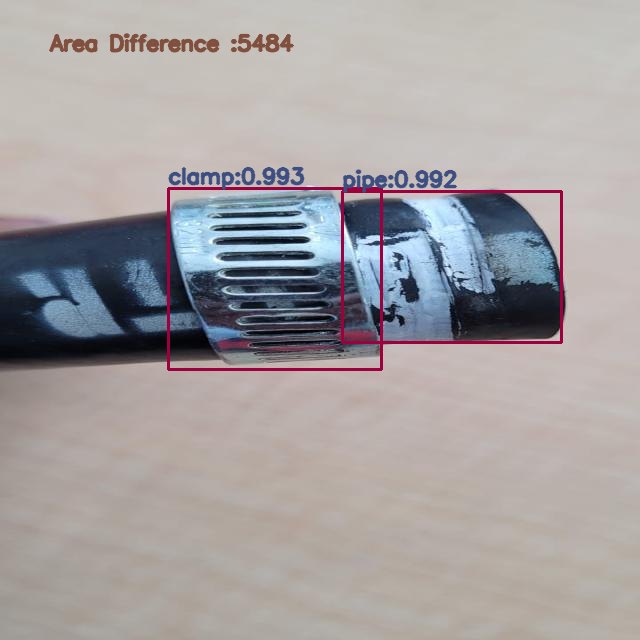

Image 2 done...
--------------------------------------------------


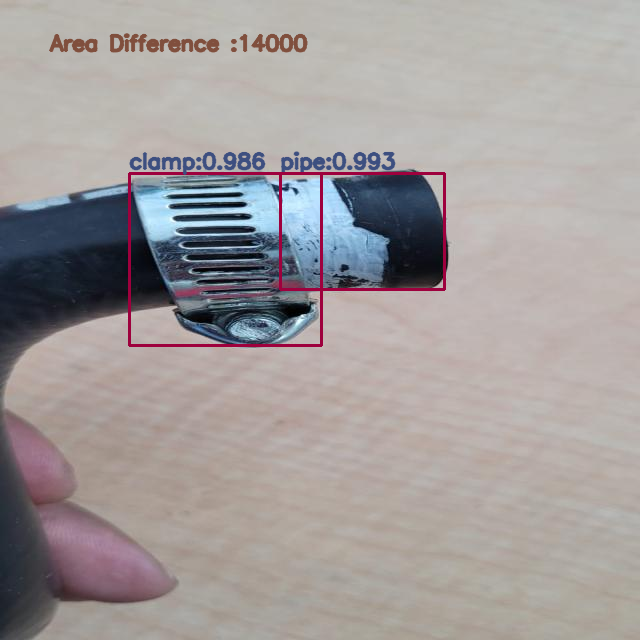

Image 2 done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE


In [53]:
for i in range(len(test_images)):
    # get the image file name for saving output later on
    image_name = test_images[i].split('/')[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float64)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cpu()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image)

    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

        for i,box in enumerate(draw_boxes):
          area = abs(box[0] - box[2]) * abs(box[1] - box[3])
          if pred_classes[i] == 'clamp':
            clamp_area = area
          else:
            pipe_area = area

        area_difference = abs(clamp_area - pipe_area)
        area_str = "Area Difference :" + str(area_difference)

        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            text_value = pred_classes[j] + ":" +"{:.3f}".format(scores[j])
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (61, 0, 158), 2)
            # # Fill the rectangle
            # cv2.rectangle(orig_image,
            #             (int(box[0]), int(box[1])),
            #             (int(box[2]), int(box[3])),
            #             (117,124,221), thickness=-1)

            cv2.putText(orig_image, text_value,
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (128, 79, 61),
                        2, lineType=cv2.LINE_AA)

            cv2.putText(orig_image, area_str,
                        (50,50),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (61, 79, 128),
                        2, lineType=cv2.LINE_AA)
        cv2_imshow(orig_image)
        cv2.waitKey(1)
        cv2.imwrite(f"/content/drive/MyDrive/Gaspipe_Project/test_output/{image_name}.jpg", orig_image,)
    print(f"Image {i+1} done...")
    print('-'*50)
print('TEST PREDICTIONS COMPLETE')
cv2.destroyAllWindows()